In [1]:
from netgan.netgan import *
import tensorflow as tf
from netgan import utils
import scipy.sparse as sp
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
import time

%matplotlib inline

/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hheidrich/miniconda3/envs/ne

#### Load the data

In [2]:
_A_obs, _X_obs, _z_obs = utils.load_npz('data/cora_ml.npz')
_A_obs = _A_obs + _A_obs.T
_A_obs[_A_obs > 1] = 1
lcc = utils.largest_connected_components(_A_obs)
_A_obs = _A_obs[lcc,:][:,lcc]
_N = _A_obs.shape[0]

Selecting 1 largest connected components


In [3]:
val_share = 0.1
test_share = 0.05
seed = 481516234

#### Load the train, validation, test split from file

In [4]:
def load(*a,**k):
    return np.load(*a, allow_pickle=True, **k)

loader = load('pretrained/cora_ml/split.npy').item()

In [5]:
train_ones = loader['train_ones']
val_ones = loader['val_ones']
val_zeros = loader['val_zeros']
test_ones = loader['test_ones']
test_zeros = loader['test_zeros']

In [6]:
train_graph = sp.coo_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1]))).tocsr()
assert (train_graph.toarray() == train_graph.toarray().T).all()

#### Parameters

In [7]:
rw_len = 16
batch_size = 128

In [8]:
walker = utils.RandomWalker(train_graph, rw_len, p=1, q=1, batch_size=batch_size)

#### Create our NetGAN model

In [9]:
netgan = NetGAN(_N, rw_len, walk_generator= walker.walk, gpu_id=0, use_gumbel=True, disc_iters=3,
                W_down_discriminator_size=32, W_down_generator_size=128,
                l2_penalty_generator=1e-7, l2_penalty_discriminator=5e-5,
                generator_layers=[40], discriminator_layers=[30], temp_start=5, temperature_decay=0.99998, learning_rate=0.0003, legacy_generator=True)




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`,


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### Load pretrained model

In [10]:
saver = tf.train.Saver()
saver.restore(netgan.session, "pretrained/cora_ml/pretrained_gen.ckpt")

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from pretrained/cora_ml/pretrained_gen.ckpt


#### Generate random walks on the trained model

In [11]:
sample_many = netgan.generate_discrete(10000, reuse=True, legacy=True)

In [12]:
rws = utils.sample_rws(sampler=sample_many, sampler_args={netgan.tau: 0.5}, steps=6000)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000


#### Assemble score matrix from the random walks

In [13]:
scores_matrix = utils.score_matrix_from_random_walks(rws, _N)

#### Compute graph statistics

In [17]:
A_select = sp.csr_matrix((np.ones(len(train_ones)), (train_ones[:,0], train_ones[:,1])))

In [18]:
A_select = train_graph

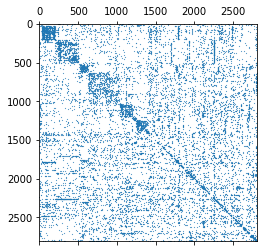

In [19]:
sampled_graph = utils.graph_from_scores(scores_matrix, A_select.sum())
plt.spy(sampled_graph, markersize=.2)
plt.show()

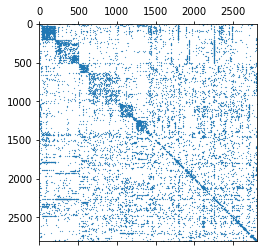

In [20]:
plt.spy(A_select, markersize=.2)
plt.show()

In [21]:
utils.edge_overlap(A_select.toarray(), sampled_graph)/A_select.sum()

0.5190918472652218

In [22]:
utils.compute_graph_statistics(sampled_graph)

/home/hheidrich/miniconda3/envs/netgan/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


{'d_max': 205.0,
 'd_min': 1.0,
 'd': 4.8277580071174375,
 'LCC': 2800,
 'wedge_count': 81583.0,
 'claw_count': 1975037.9999999998,
 'triangle_count': 1526,
 'square_count': 66,
 'power_law_exp': 1.79154664505714,
 'gini': 0.42100284204335425,
 'rel_edge_distr_entropy': 0.9543738672256469,
 'assortativity': -0.07139321328353222,
 'clustering_coefficient': 0.0023179300853958256,
 'n_components': 4,
 'cpl': 5.178022637595844}

In [23]:
utils.compute_graph_statistics(A_select.toarray())

{'d_max': 240.0,
 'd_min': 1.0,
 'd': 4.8277580071174375,
 'LCC': 2810,
 'wedge_count': 101872.0,
 'claw_count': 3094240.0,
 'triangle_count': 2814,
 'square_count': 517,
 'power_law_exp': 1.85595899191131,
 'gini': 0.48239580529720794,
 'rel_edge_distr_entropy': 0.9407067745192429,
 'assortativity': -0.07543032480414193,
 'clustering_coefficient': 0.0027282951548684006,
 'n_components': 1,
 'cpl': 5.60937302442961}